In [1]:
%matplotlib inline
# Retina
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import tracemalloc
import matplotlib.pyplot as plt

In [2]:
class NaiveKNN:
    def __init__(self):
        self.data = None

    def fit(self, X):
        self.data = X

    def query(self, query_pt, k=1):
        distances = np.linalg.norm(self.data - query_pt, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return nearest_indices


In [3]:
import time
import tracemalloc

def benchmark_knn(knn, X, query_pt, k):
    tracemalloc.start()
    start_time = time.perf_counter()
    knn.fit(X)
    fit_time = time.perf_counter() - start_time
    current_memory, fit_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tracemalloc.start() 
    start_time = time.perf_counter()
    knn.query(query_pt, k)
    query_time = time.perf_counter() - start_time
    current_memory, query_memory = tracemalloc.get_traced_memory() 
    tracemalloc.stop()

    return fit_time, query_time, fit_memory, query_memory


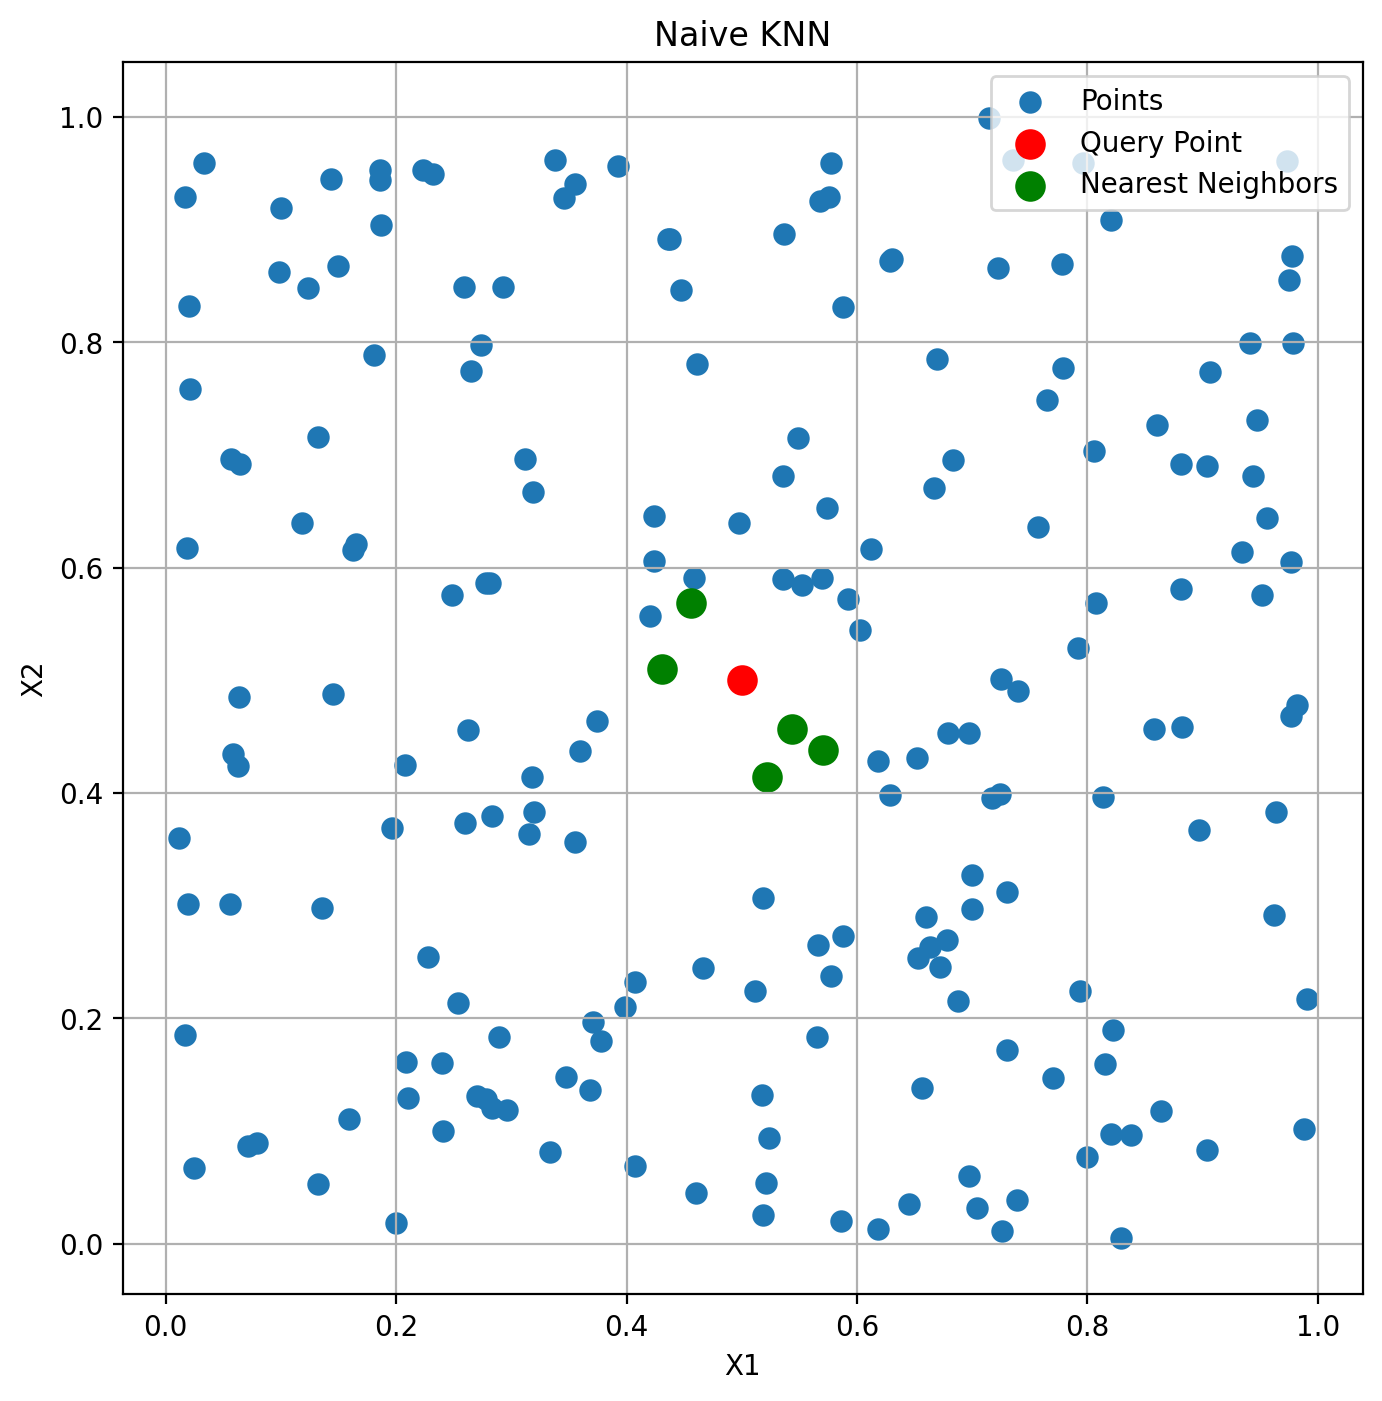

In [4]:
np.random.seed(0)
X_2d = np.random.rand(200, 2)
query_pt_2d = np.array([0.5, 0.5])


naive_2d = NaiveKNN()
naive_2d.fit(X_2d)
naive_indices = naive_2d.query(query_pt_2d, k=5)

plt.figure(figsize=(8, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], label="Points", s=50)
plt.scatter(query_pt_2d[0], query_pt_2d[1], color='red', label="Query Point", s=100)
plt.scatter(X_2d[naive_indices, 0], X_2d[naive_indices, 1], color='green', label="Nearest Neighbors", s=100)

plt.legend()
plt.title("Naive KNN")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()


In [5]:
class KDTree:
    def __init__(self, min_samples_split=8):
        self.min_samples_split = min_samples_split
        self.tree = None
        self.splits = []
        self.leafs= []

    def fit(self, X):
        self.tree = self._build_tree(X)


    def _build_tree(self, X, depth=0):
        if len(X) <= self.min_samples_split:
            self.leafs.append(X)
            return X

        dim = depth % X.shape[1]

        X = X[X[:, dim].argsort()]

        median_idx = len(X) // 2
        self.splits.append((X[median_idx, dim], dim))
        return {
            'dim': dim,
            'val': X[median_idx, dim],
            'left': self._build_tree(X[:median_idx], depth + 1),
            'right': self._build_tree(X[median_idx:], depth + 1)
        }

    def query_helper(self, node, query_pt, k):
        if isinstance(node, np.ndarray):
            return node

        dim = node['dim']
        val = node['val']

        if query_pt[dim] < val:
            return self.query_helper(node['left'], query_pt, k)
        else:
            return self.query_helper(node['right'], query_pt, k)
        
    def naive(self, arr : np.ndarray, query_pt, k):
        distances = np.linalg.norm(arr - query_pt, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return arr[nearest_indices]
    def query(self, query_pt, k=1):
        nparr = (self.query_helper(self.tree, query_pt, k))
        return self.naive(nparr, query_pt, k)
    

In [6]:
def plot_partitions_kdtree(node : dict, x_min, x_max, y_min, y_max):
    if isinstance(node, np.ndarray):
        return

    dim = node['dim']
    val = node['val']

    if dim == 0:
        plt.plot([val, val], [y_min, y_max], color='black')
        plot_partitions_kdtree(node['left'], x_min, val, y_min, y_max)
        plot_partitions_kdtree(node['right'], val, x_max, y_min, y_max)
    else:
        plt.plot([x_min, x_max], [val, val], color='black')
        plot_partitions_kdtree(node['left'], x_min, x_max, y_min, val)
        plot_partitions_kdtree(node['right'], x_min, x_max, val, y_max)

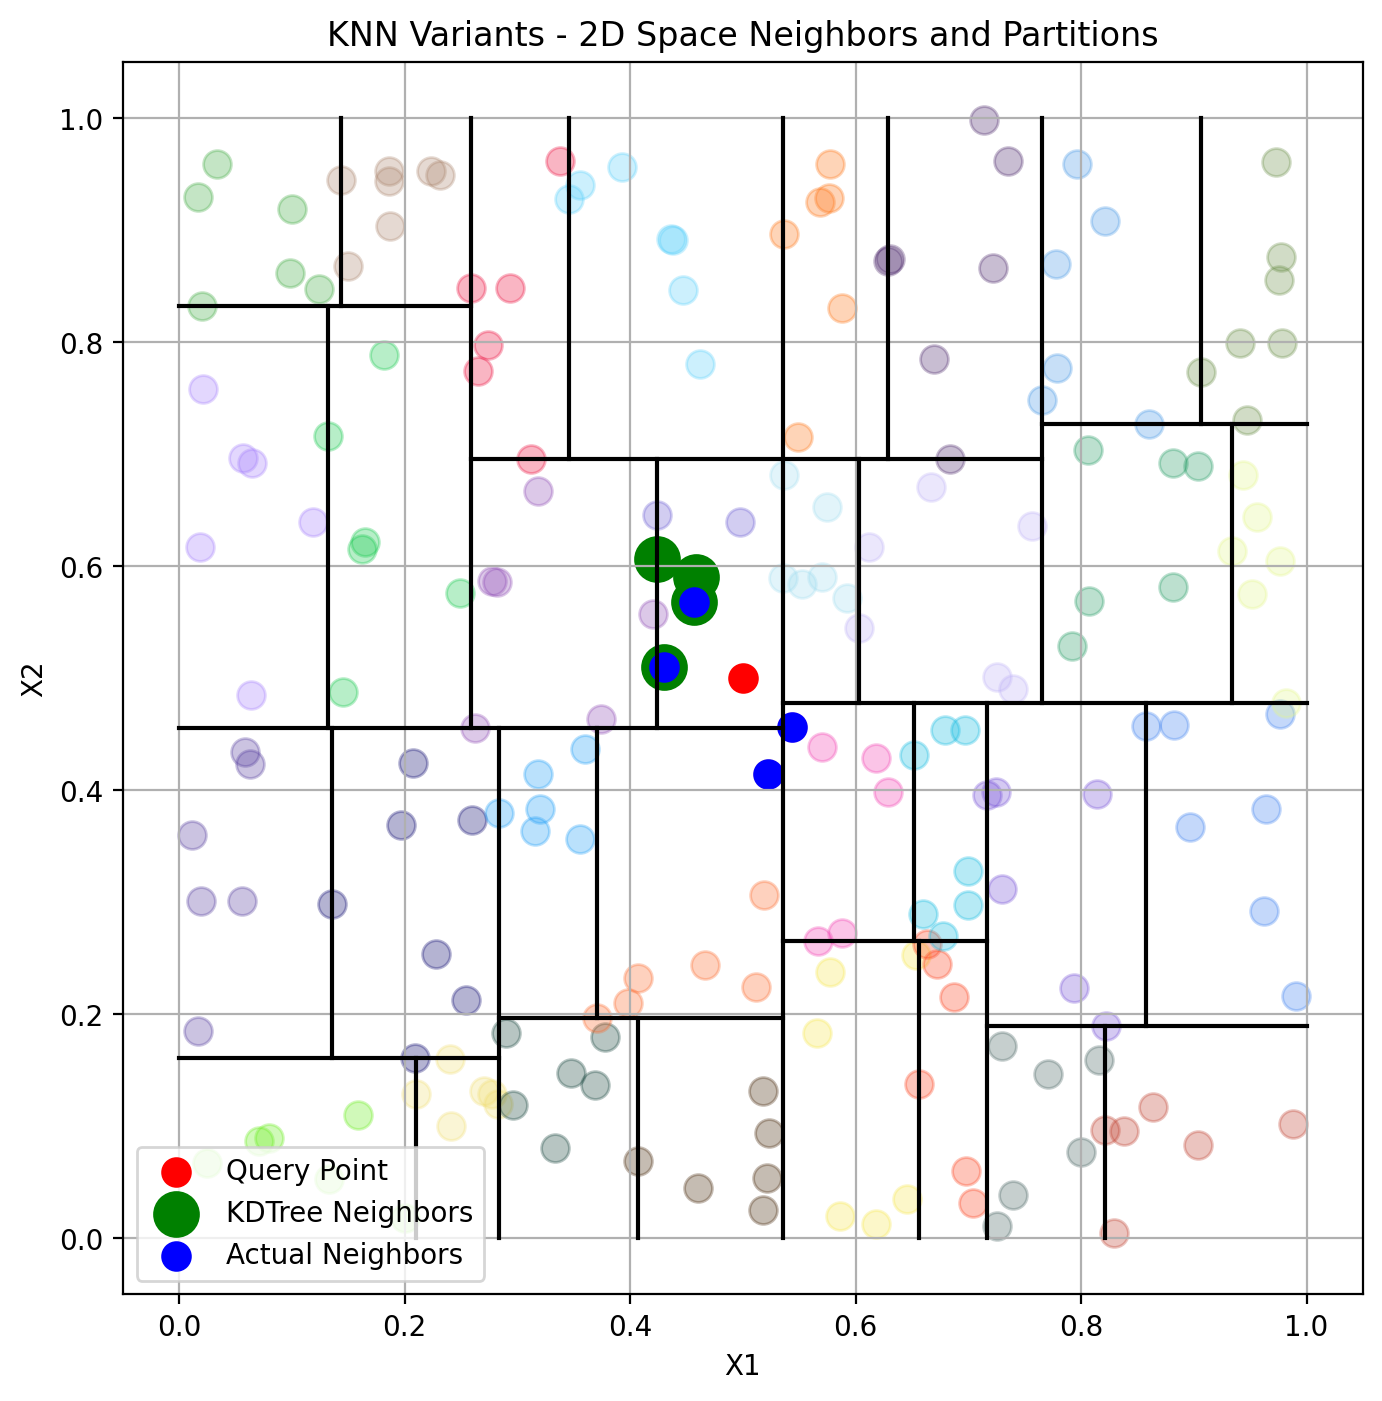

In [7]:
kdtree = KDTree()
kdtree.fit(X_2d)
kdtree_points = kdtree.query(query_pt_2d, k=4)

naive_2d_knnfalse = NaiveKNN()
naive_2d_knnfalse.fit(X_2d)
naive_indices = naive_2d.query(query_pt_2d, k=4)

plt.figure(figsize=(8, 8))

for i in kdtree.leafs:
    plt.scatter(i[:, 0], i[:, 1], color= np.random.rand(3,), s=100, alpha=0.3)

plt.scatter(query_pt_2d[0], query_pt_2d[1], color='red', label="Query Point", s=100)
plt.scatter(kdtree_points[:, 0], kdtree_points[:, 1], color='green', label="KDTree Neighbors", s= 250)
plt.scatter(X_2d[naive_indices, 0], X_2d[naive_indices, 1], color='blue', label="Actual Neighbors", s=100)

plt.legend()
plt.title("KDTree KNN")
plt.title("KNN Variants - 2D Space Neighbors and Partitions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plot_partitions_kdtree(kdtree.tree, 0, 1, 0, 1)
plt.show()


In [8]:
class LSH:
    def __init__(self, n_projections=10, radomn_seed = 42):
        self.random_seed = radomn_seed
        np.random.seed(radomn_seed)
        self.n_projections = n_projections
        self.projections = None
        self.hash_table = {}

    def fit(self, X):
        np.random.seed(self.random_seed)
        self.projections = np.random.randn(X.shape[1] + 1, self.n_projections)
        X_aug = np.hstack([ np.ones((X.shape[0], 1)), X])
        X__ = X_aug @ self.projections
        X_str = np.array([''.join('1' if i > 0 else '0' for i in list(x)) for x in X__])
        for i, x in enumerate(X_str):
            if x not in self.hash_table:
                self.hash_table[x] = []
            self.hash_table[x].append(X_aug[i,1:])

        for x in self.hash_table:
            self.hash_table[x] = np.array(self.hash_table[x])

    
    def naive(self, arr : np.ndarray, query_pt, k):
        distances = np.linalg.norm(arr - query_pt, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return arr[nearest_indices]
    

    def query(self, query_pt, k=1):
        np.random.seed(self.random_seed)
        query_pt_ = np.hstack([1, query_pt])
        projs = query_pt_ @ self.projections
        hash__ = ''.join('1' if i > 0 else '0' for i in list(projs))
        if hash__ not in self.hash_table:
            return []
    
        return self.naive(self.hash_table[hash__], query_pt, k)

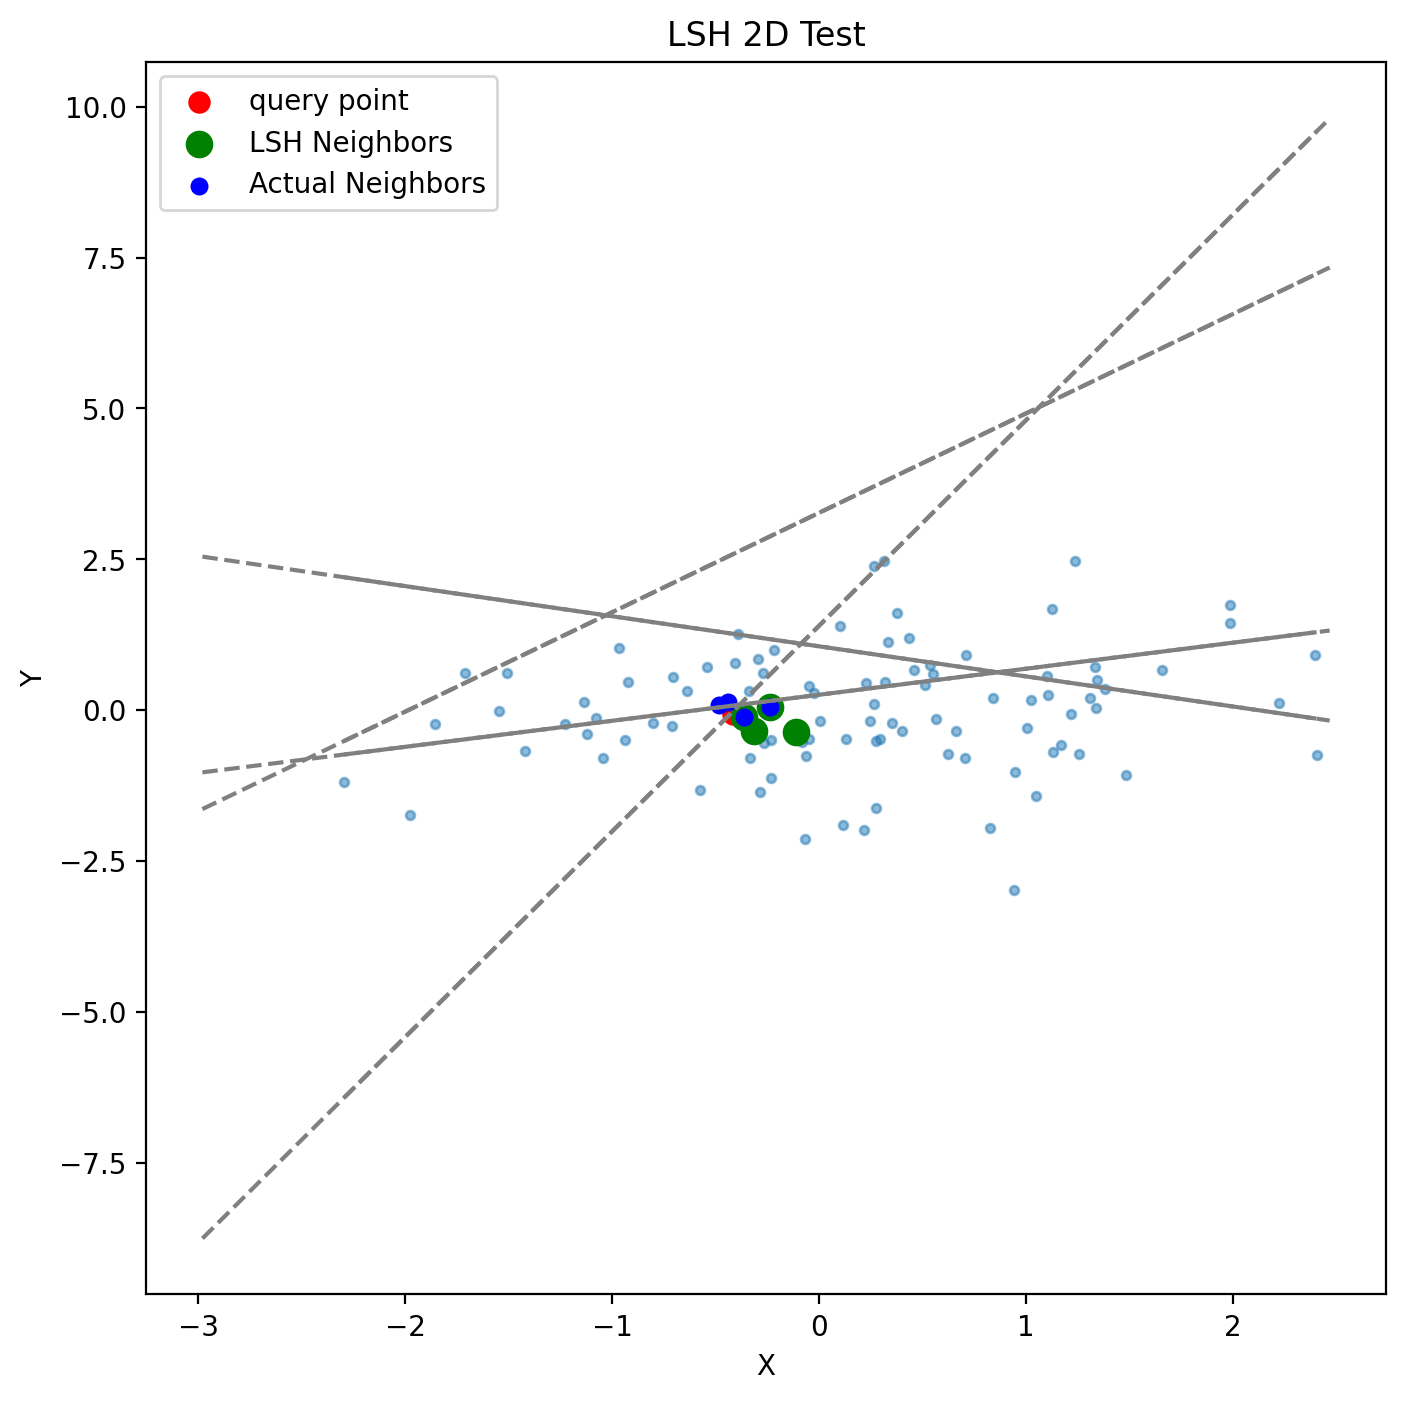

[[-0.36249918 -0.12190569]
 [-0.23700418  0.05728515]
 [-0.31282876 -0.34888192]
 [-0.11227247 -0.36218045]]
[34 48 58 77]


In [9]:
np.random.seed(10)
n = 100
X = np.random.randn(n, 2)


np.random.seed(2)
query_pt = np.random.randn(2)

naive_2d_lshfalse = NaiveKNN()
naive_2d_lshfalse.fit(X)
naive_indices = naive_2d_lshfalse.query(query_pt, k=4)

lsh = LSH(n_projections=4, radomn_seed=42)
lsh.fit(X)

neighbors = lsh.query(query_pt, k=4)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)
ax.scatter(query_pt[0], query_pt[1], s=50, c='r', marker='o', label = 'query point')
ax.scatter(neighbors[:,0], neighbors[:,1], s=80, c='g', marker='o', label='LSH Neighbors')
ax.scatter(X[naive_indices, 0], X[naive_indices, 1], color='blue', label="Actual Neighbors", s=30)
for i in range(lsh.n_projections):
    intercept = -lsh.projections[0, i]/lsh.projections[2, i]
    slope = -lsh.projections[1, i] / lsh.projections[2, i]
    x_values = np.linspace(np.min(X, axis = 0), np.max(X, axis = 0), 100)
    plt.plot(x_values, slope * x_values + intercept, linestyle='--', color='gray')

ax.set_title('LSH 2D Test')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.legend()
plt.show()

print(neighbors)
print(naive_indices)

Varying $N$(dataset size) and $D$(number of dimensions) and testing

<Figure size 1000x600 with 0 Axes>

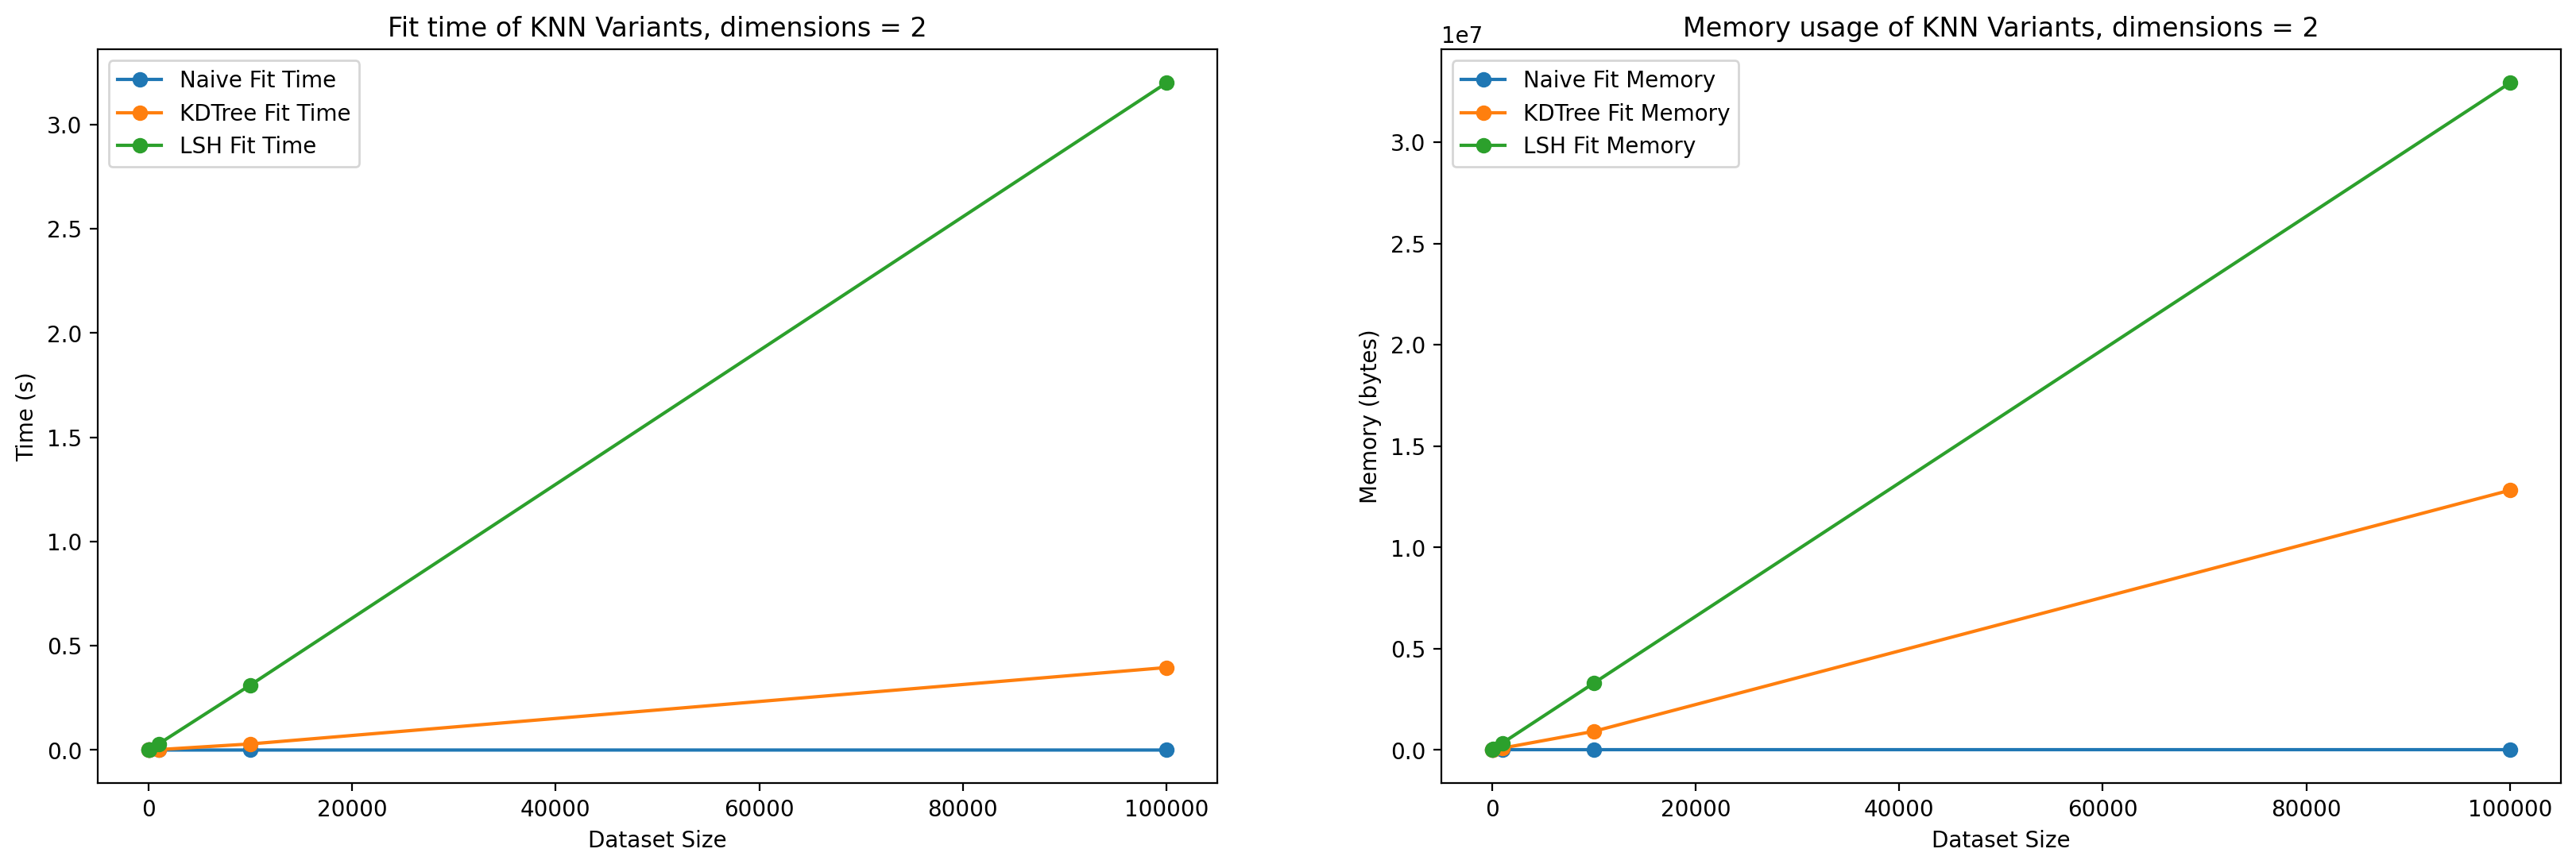

<Figure size 1000x600 with 0 Axes>

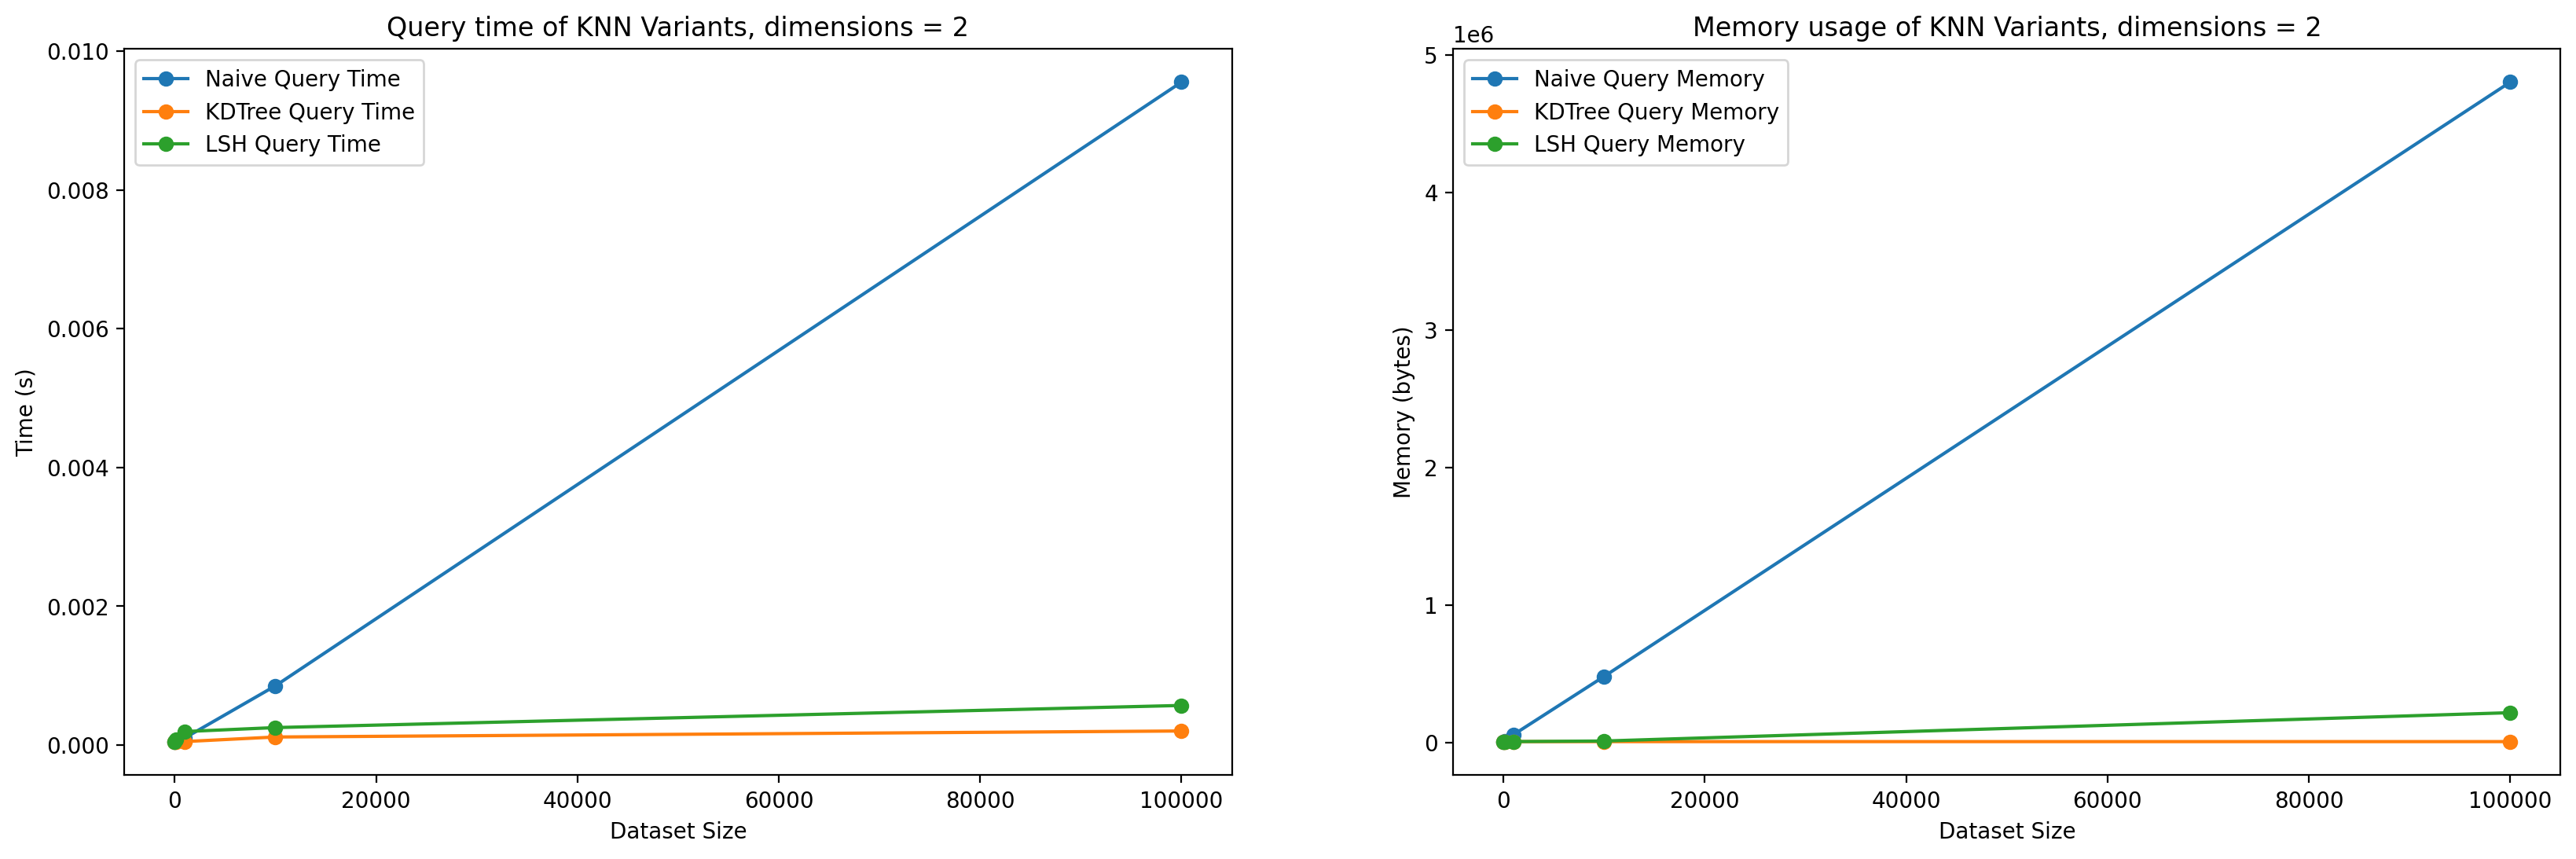

<Figure size 1000x600 with 0 Axes>

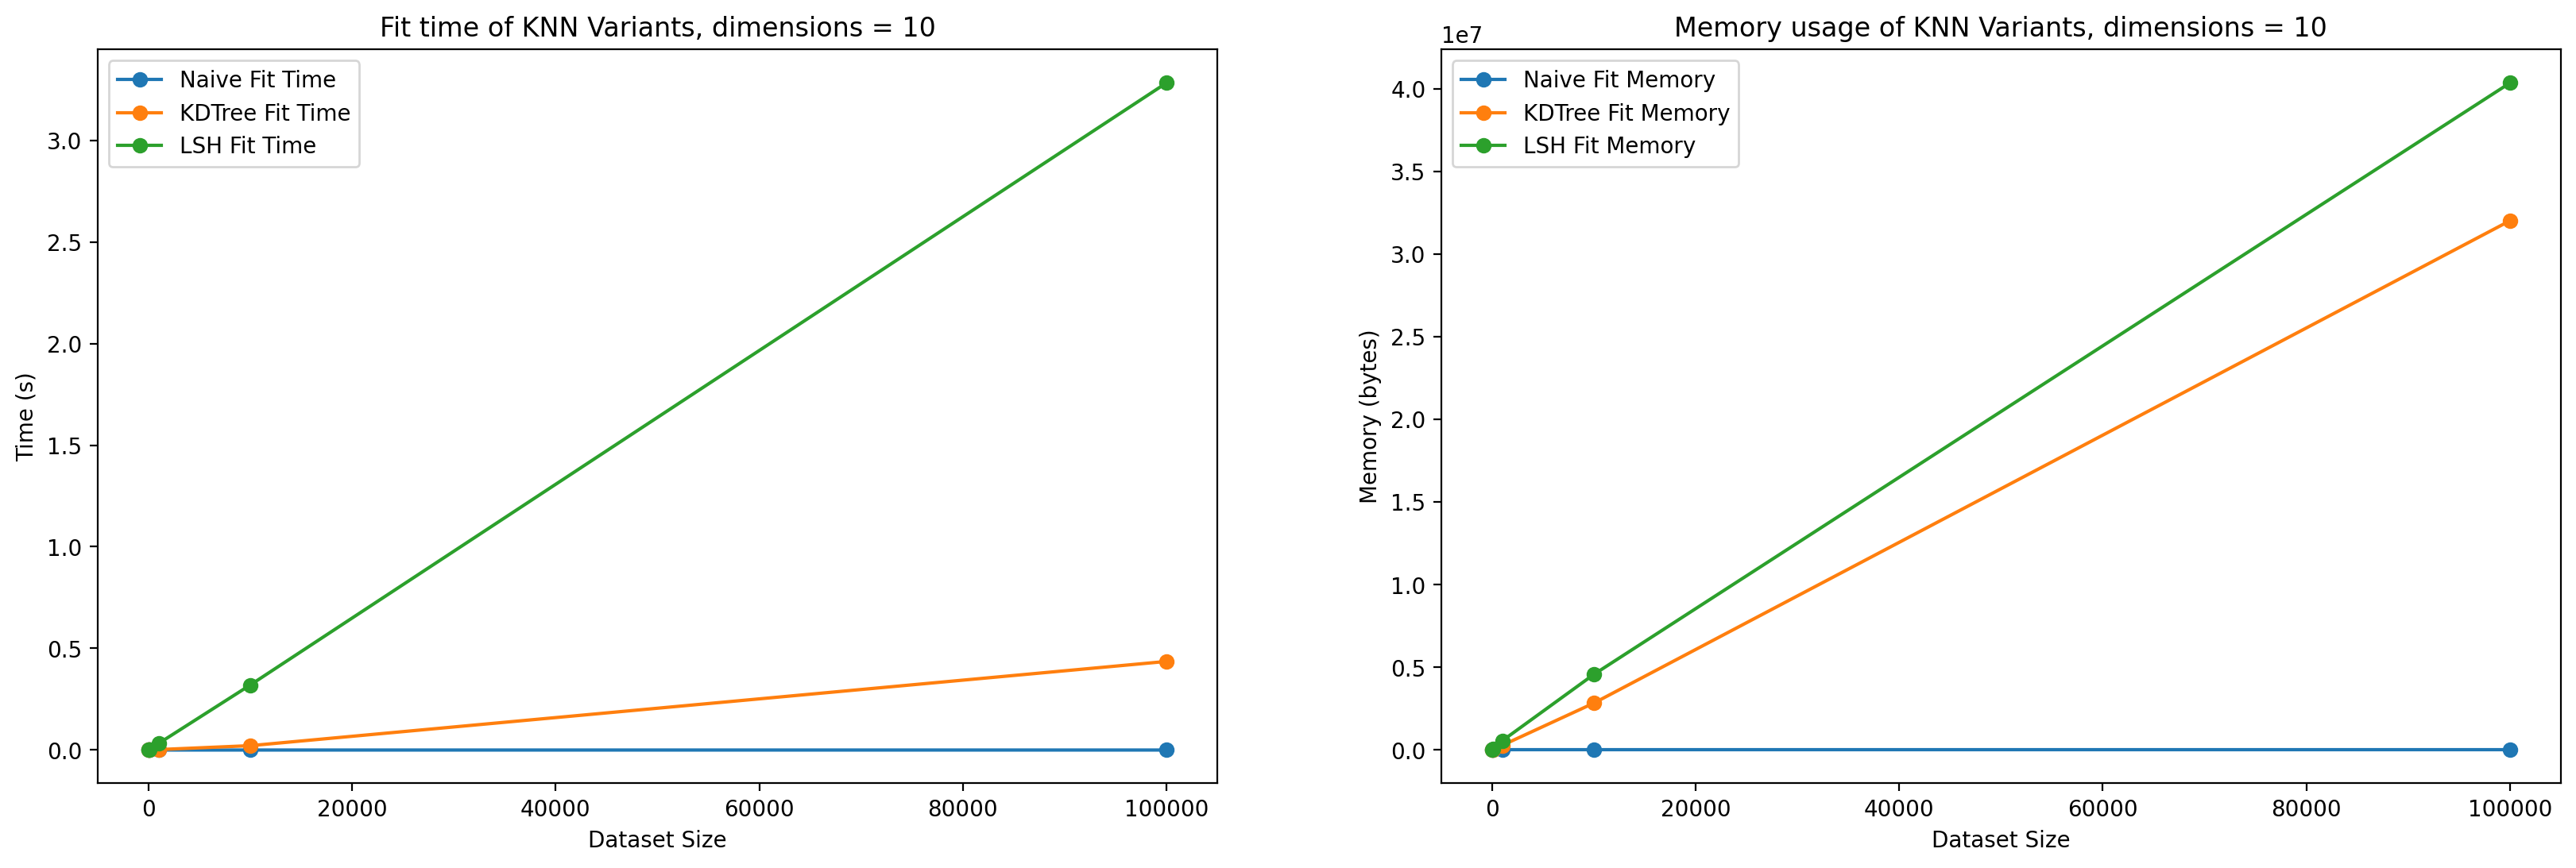

<Figure size 1000x600 with 0 Axes>

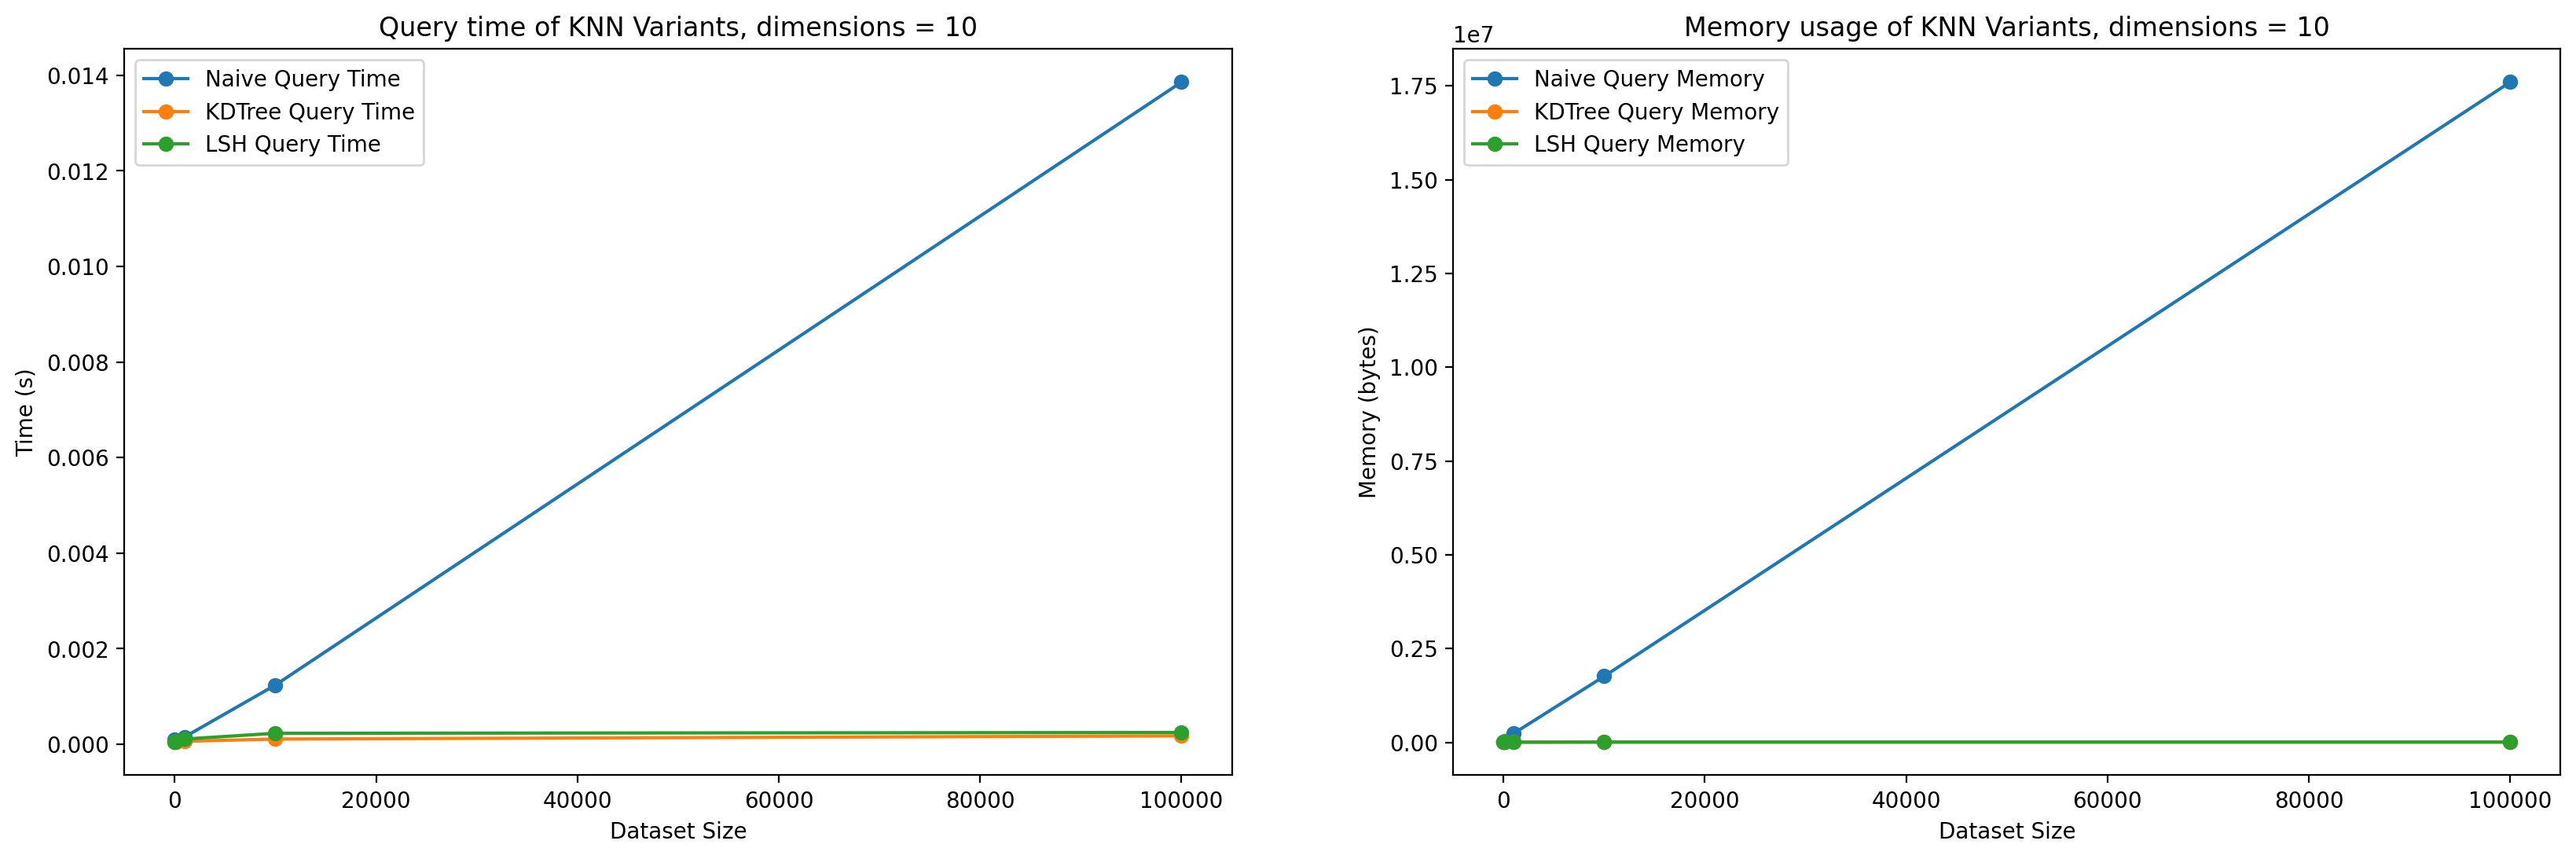

<Figure size 1000x600 with 0 Axes>

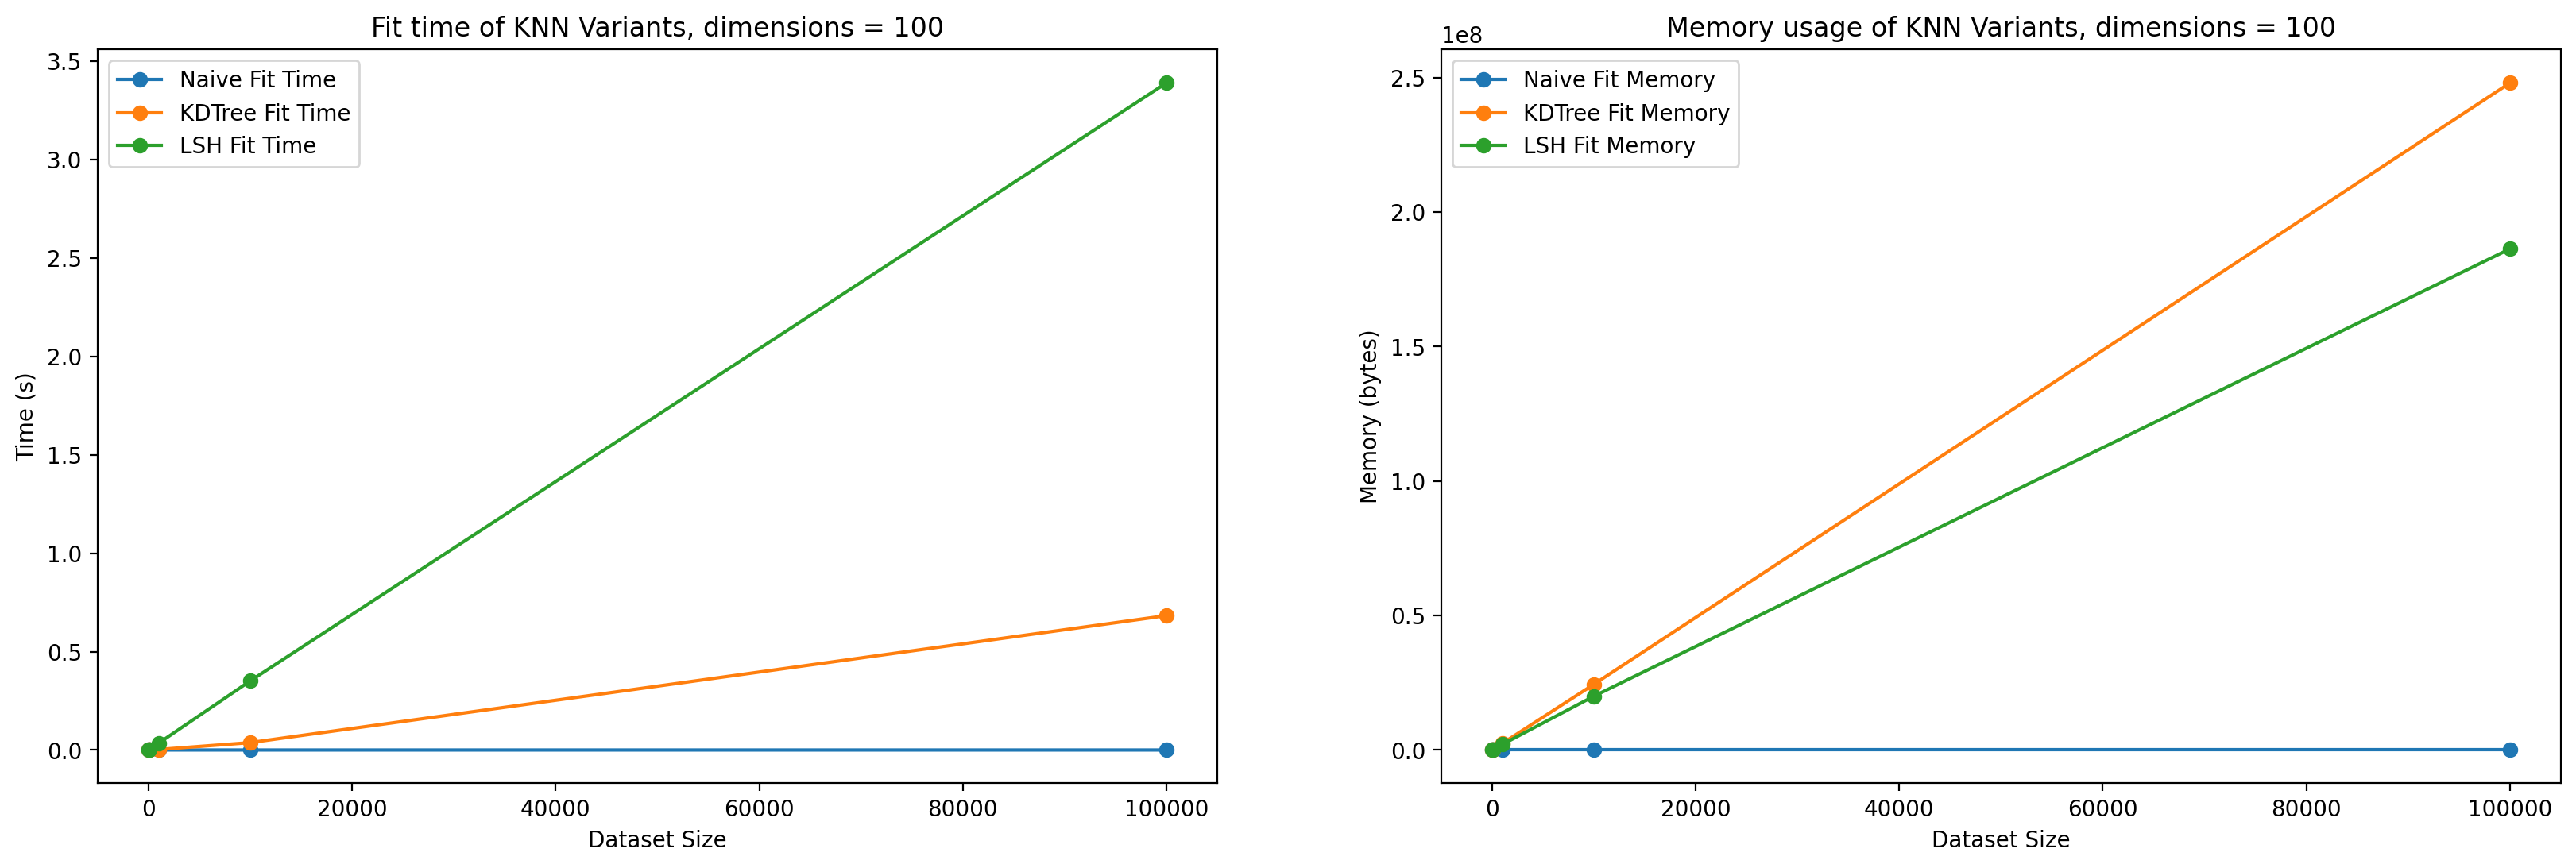

<Figure size 1000x600 with 0 Axes>

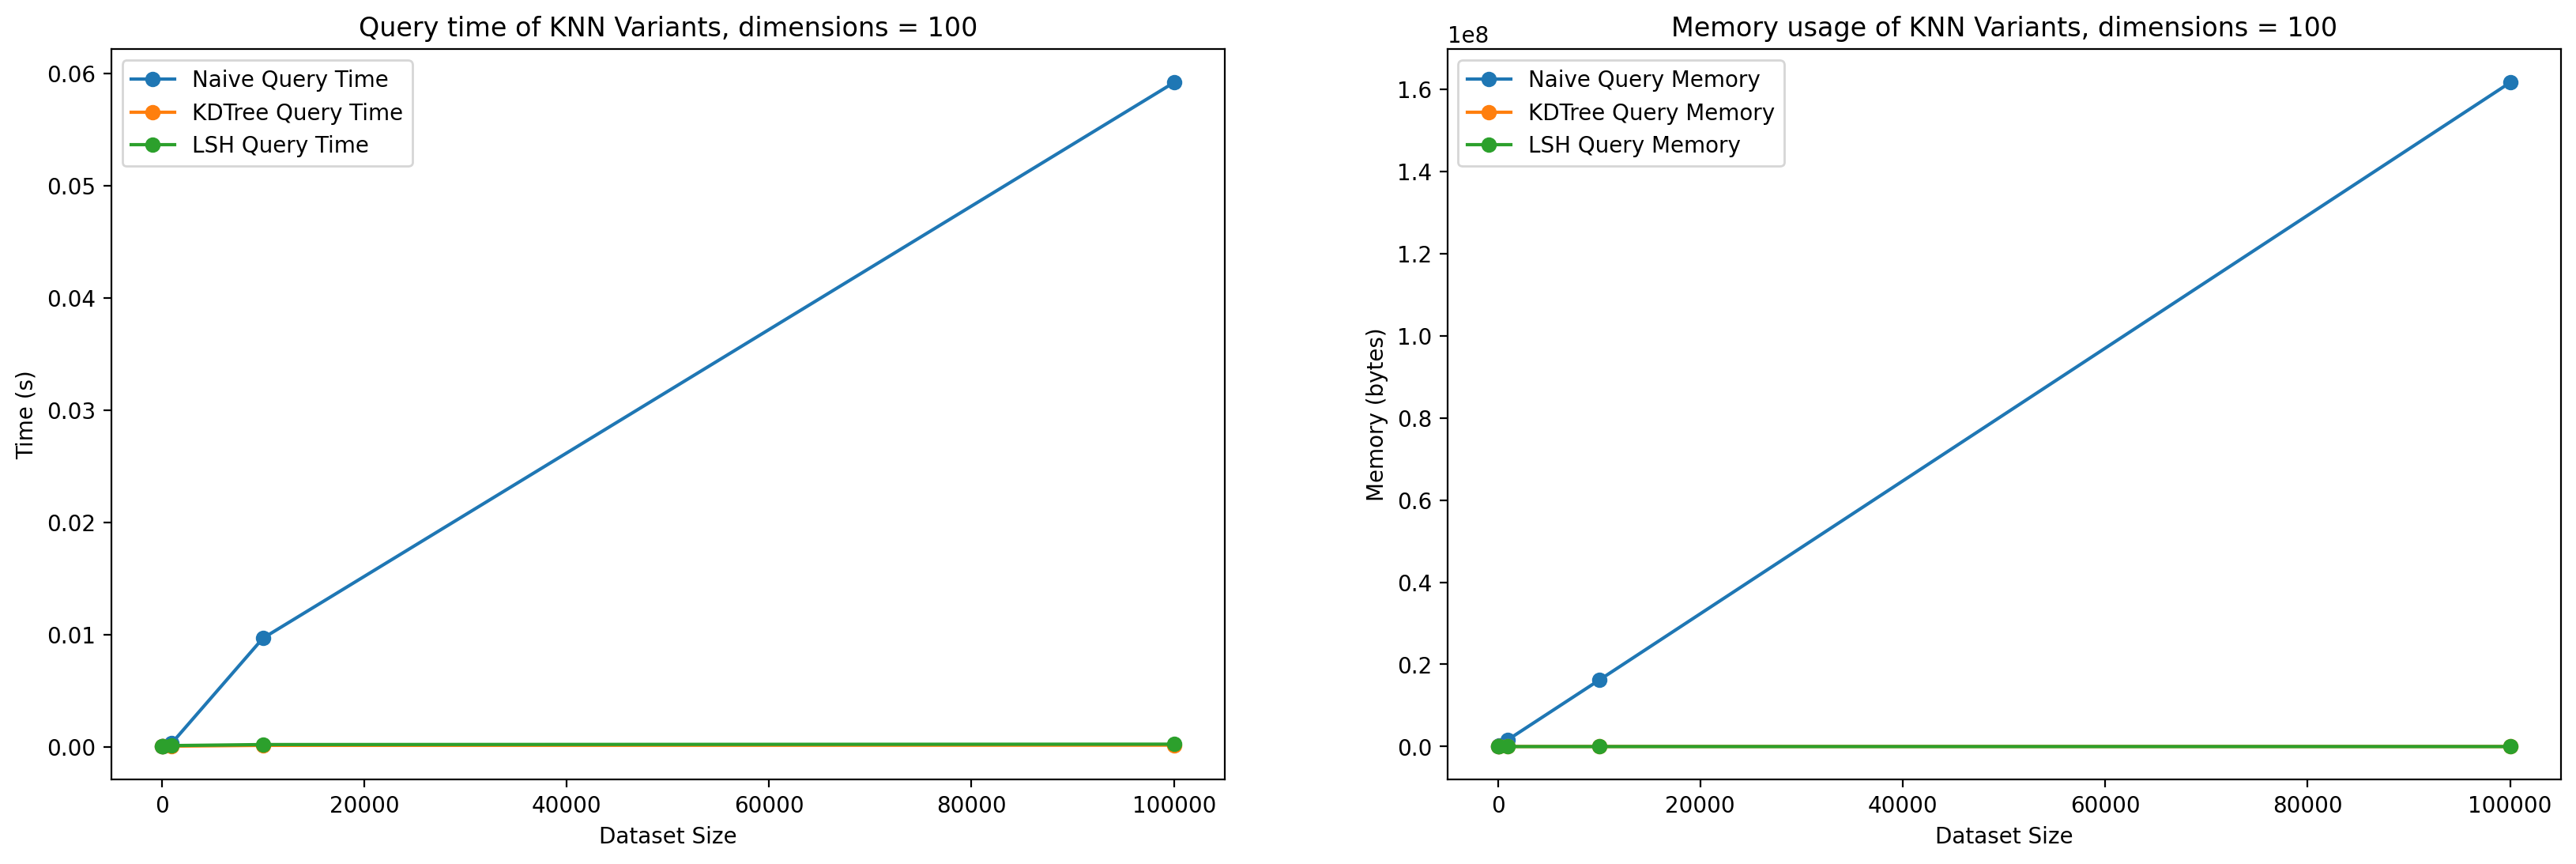

<Figure size 1000x600 with 0 Axes>

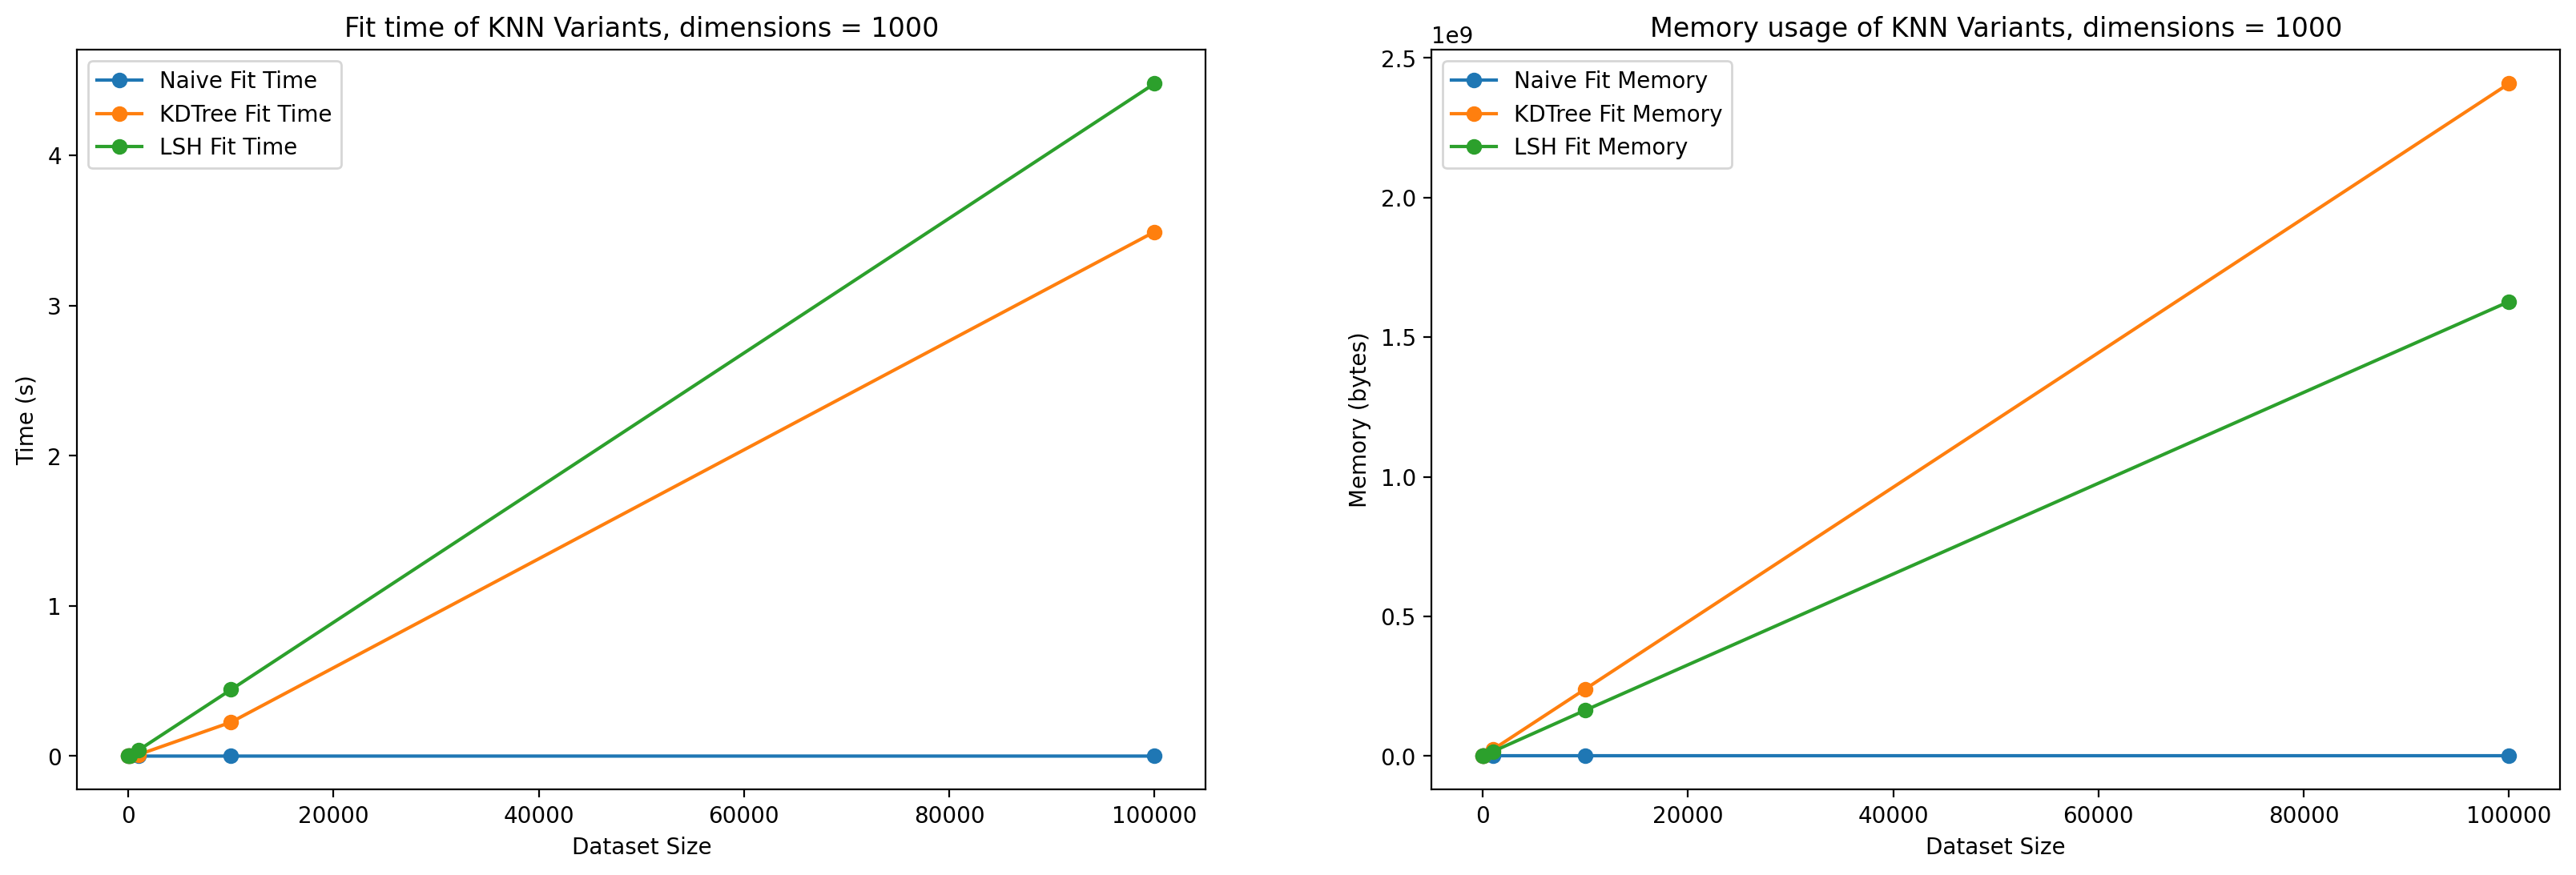

<Figure size 1000x600 with 0 Axes>

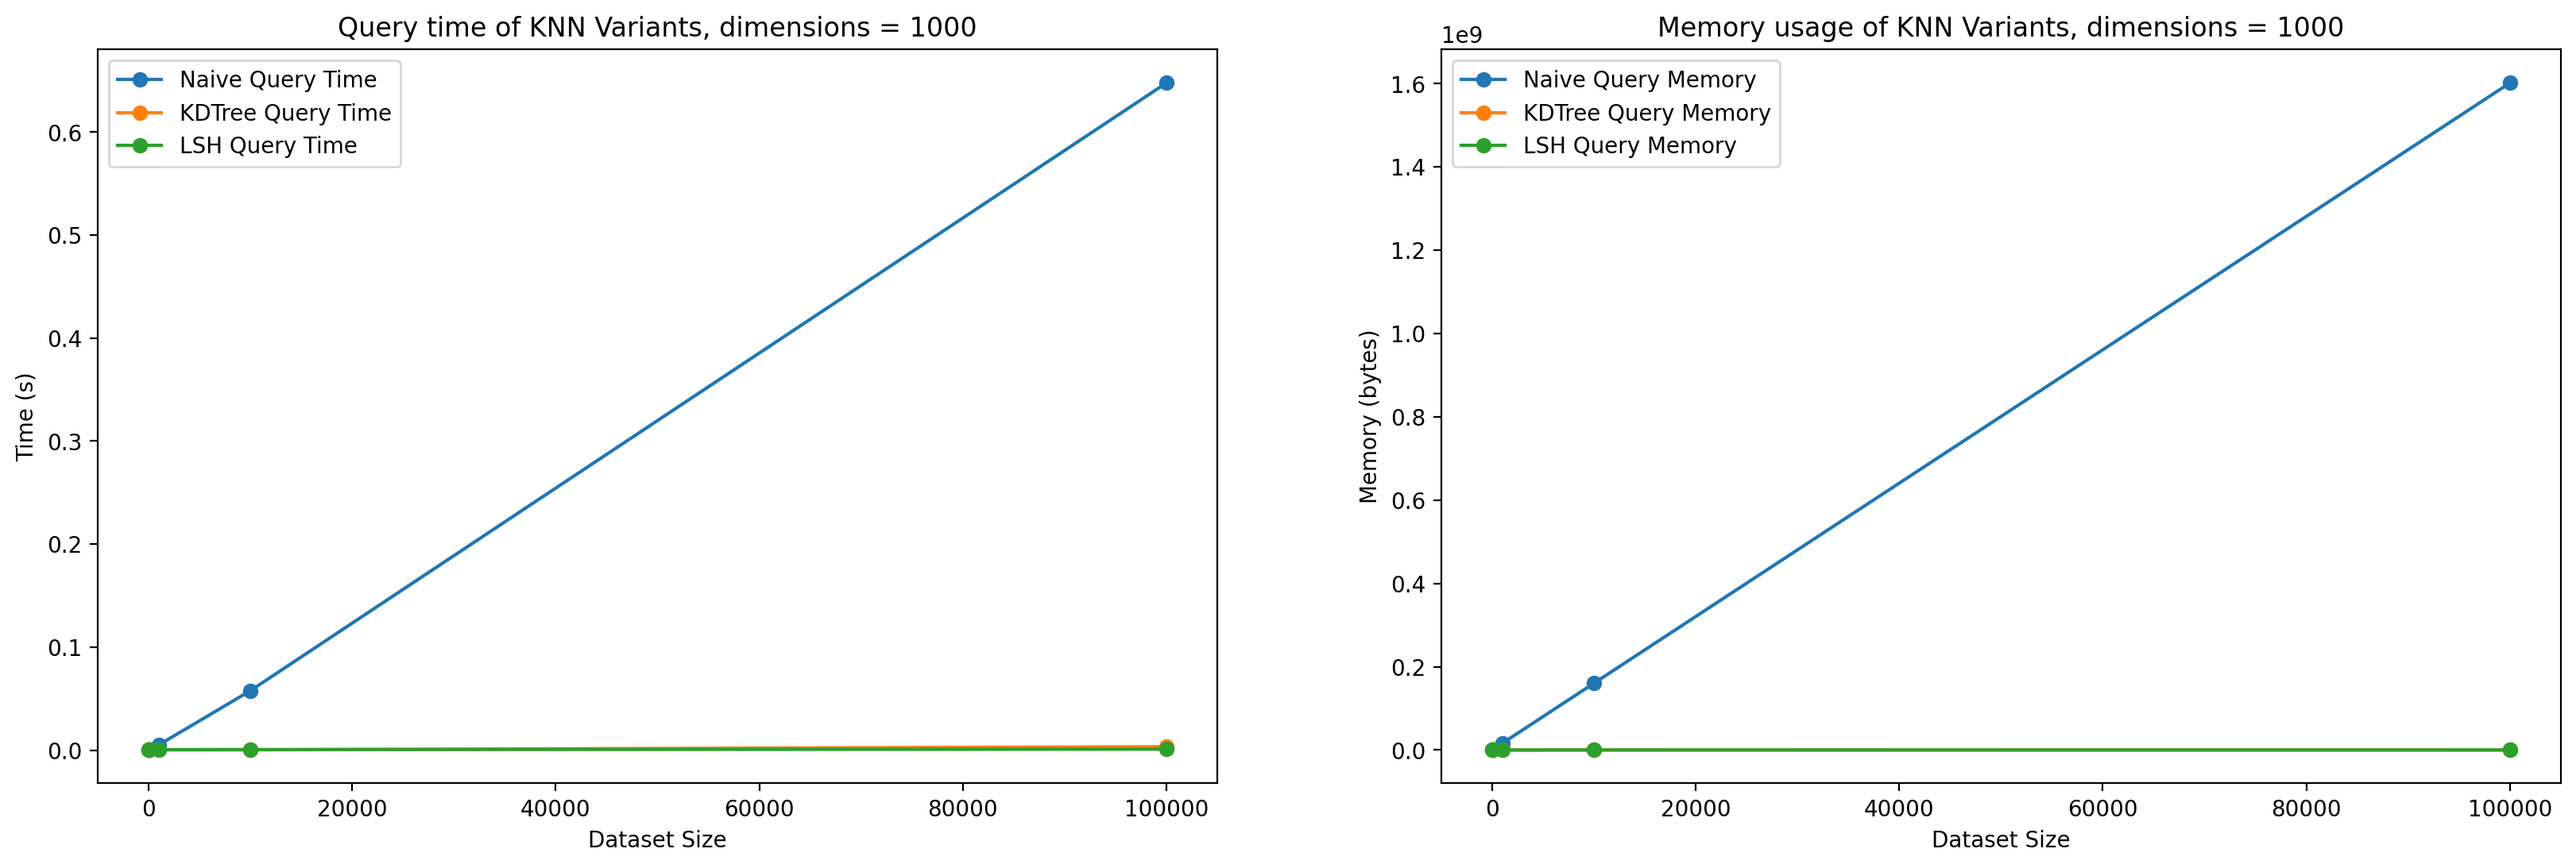

In [10]:
dataset_sizes = [10, 100, 1000, 10000, 100000]
dimensions = [2, 10, 100, 1000]

def benchmark_knn_all_plot(dimensions, dataset_sizes, n_neighbors=2, random_seed=42, n_iterations=8):      
    naive_times = []
    kdtree_times = []
    lsh_times = []
    for n in dataset_sizes:
        naive_time_accum = np.zeros(4)
        kdtree_time_accum = np.zeros(4)
        lsh_time_accum = np.zeros(4)
        for _ in range(n_iterations):
            X = np.random.randn(n, dimensions)
            query_pt = np.random.randn(dimensions)
            naive_knn = NaiveKNN()
            kdtree = KDTree(min_samples_split=10)
            lsh = LSH(n_projections=15, radomn_seed=42)

            naive_time = benchmark_knn(naive_knn, X, query_pt, n_neighbors)
            kdtree_time = benchmark_knn(kdtree, X, query_pt, n_neighbors)
            lsh_time = benchmark_knn(lsh, X, query_pt, n_neighbors)

            naive_time_accum += np.array(naive_time)
            kdtree_time_accum += np.array(kdtree_time)
            lsh_time_accum += np.array(lsh_time)

        naive_times.append(naive_time_accum / n_iterations)
        kdtree_times.append(kdtree_time_accum / n_iterations)
        lsh_times.append(lsh_time_accum / n_iterations)

    naive_times = np.array(naive_times)
    kdtree_times = np.array(kdtree_times)
    lsh_times = np.array(lsh_times)

    plt.figure(figsize=(10, 6))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.plot(dataset_sizes, naive_times[:, 0], label="Naive Fit Time", marker='o')
    ax1.plot(dataset_sizes, kdtree_times[:, 0], label="KDTree Fit Time", marker='o')
    ax1.plot(dataset_sizes, lsh_times[:, 0], label="LSH Fit Time", marker='o')
    ax1.set_xlabel("Dataset Size")
    ax1.set_ylabel("Time (s)")
    ax1.set_title(f"Fit time of KNN Variants, dimensions = {dimensions}")
    ax1.legend()

    ax2.plot(dataset_sizes, naive_times[:, 2], label="Naive Fit Memory", marker='o')
    ax2.plot(dataset_sizes, kdtree_times[:, 2], label="KDTree Fit Memory", marker='o')
    ax2.plot(dataset_sizes, lsh_times[:, 2], label="LSH Fit Memory", marker='o')
    ax2.set_xlabel("Dataset Size")
    ax2.set_ylabel("Memory (bytes)")
    ax2.set_title(f"Memory usage of KNN Variants, dimensions = {dimensions}")
    ax2.legend()

    plt.show()

    plt.figure(figsize=(10, 6))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    ax1.plot(dataset_sizes, naive_times[:, 1], label="Naive Query Time", marker='o')
    ax1.plot(dataset_sizes, kdtree_times[:, 1], label="KDTree Query Time", marker='o')
    ax1.plot(dataset_sizes, lsh_times[:, 1], label="LSH Query Time", marker='o')
    ax1.set_xlabel("Dataset Size")
    ax1.set_ylabel("Time (s)")
    ax1.set_title(f"Query time of KNN Variants, dimensions = {dimensions}")
    ax1.legend()

    ax2.plot(dataset_sizes, naive_times[:, 3], label="Naive Query Memory", marker='o')
    ax2.plot(dataset_sizes, kdtree_times[:, 3], label="KDTree Query Memory", marker='o')
    ax2.plot(dataset_sizes, lsh_times[:, 3], label="LSH Query Memory", marker='o')
    ax2.set_xlabel("Dataset Size")
    ax2.set_ylabel("Memory (bytes)")
    ax2.set_title(f"Memory usage of KNN Variants, dimensions = {dimensions}")
    ax2.legend()

    plt.show()

for i in dimensions:
    benchmark_knn_all_plot(i, dataset_sizes)

**$Results$**

#### **Fit time(Training time) and memory :**

* The `Naive KNN` does nothing during training time, hence uses the least amount of time and memory.

* `KDTree` makes splits on the medians along different axes in a round robin fashion and then stores the tree structure along with the points in the leaf nodes. For higher dimensions KDTree takes more memory than `LSH`, but the fit time is always lesser than it. The time complexity should be $O(N^2log N)$ since the depth of the tree is at most $logN$ and the time to sort $N$ samples to find median is NlogN, in reality it is a bit lower since we limit the depth by specifying a `min_samples_split`.

* `LSH` initialises $P$ random planes and then divides the datapoints depending on which side of the hyperplane the point lies on. It needs to store a $P \times D$ matrix to store the hyperplanes and also needs to hash each datapoint and then group them according to their hashes. This takes the most amount of time in comparision. For lower dimensions it takes more memory than KDTree, but for higher dimensions, it takes lesser memory.Time complexity to generate the planes is $O(DP)$ and time to calculate hashes for all the points is $O(NDP)$ so time complexity is $O(NDP)$.

#### **Query time and memory :**

* The `Naive KNN` has the highest query time since it needs to calculate the distance to every point in the dataset. The time complexity is $O(ND)$ to find the nearest-neighbour where $N$ is the number of points and $D$ is the number of dimensions. It also stores these distances while computing them and hence has the highest memory usage too.(Note that to find k nearest neighbours we could just run quick select k times which would require $O(Nk)$ time, if k is smaller than D, time complexity would still be $O(ND)$).

* `KDTree` has a much faster query time compared to `Naive KNN` as it only needs to traverse the tree to find the nearest neighbors. The time complexity is $O(logN)$ to find the respective leaf node for the query point.After finding the appropriate leaf node, we just do naive KNN which will have time complexity of O(NS) to find the nearest neighbour where S is the size of the leaf node.The memory usage is higher than `Naive KNN` due to the storage of the tree structure.

* In `LSH`it only needs to hash the query point and then run naive KNN among the points with the same hash. Time complexty would be $O(DP)$ for calculating the hash and $O(SD)$ to find the nearest neighbour, where S is the number of points with the same hash.


*Varying $K$ and testing* 

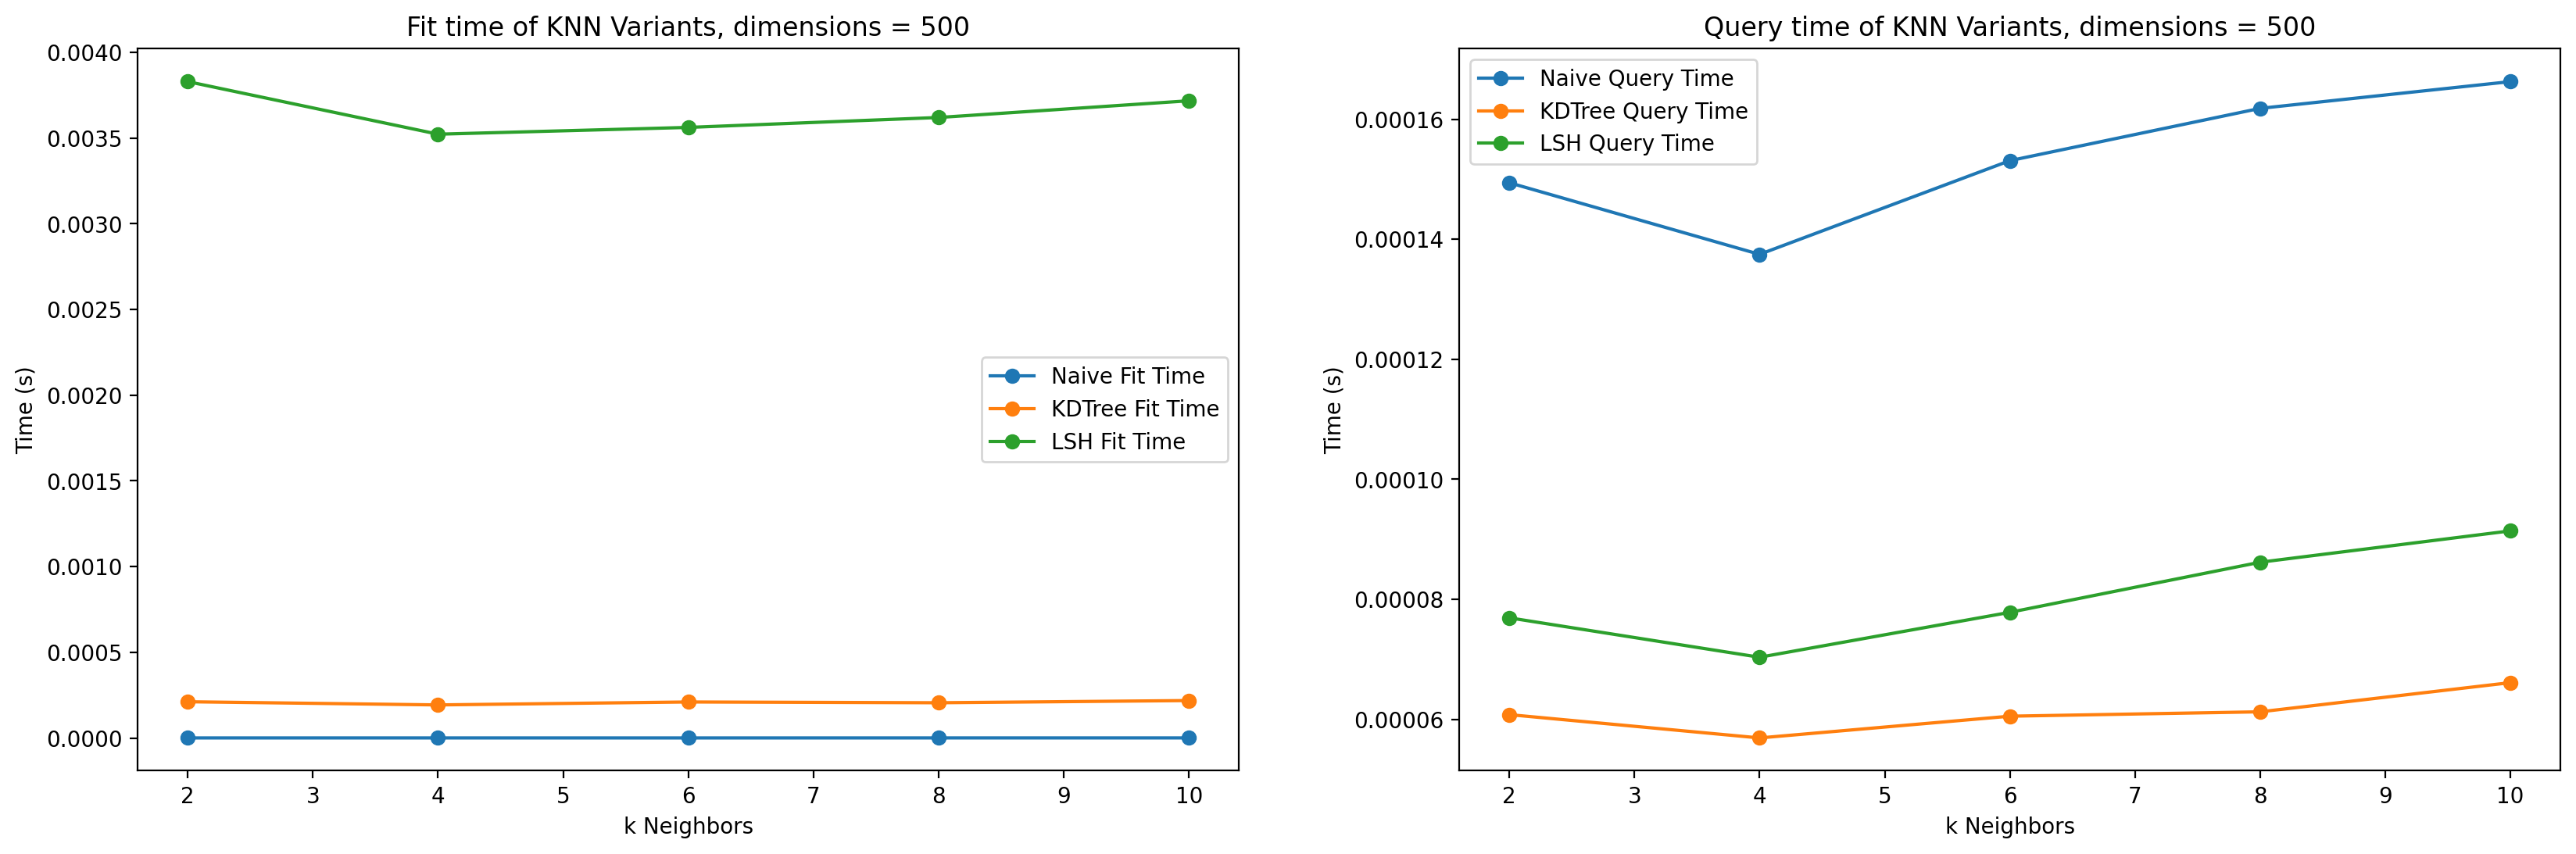

In [15]:
dataset_sizes = [10000]
dimensions = 500
vary_k = [2, 4, 6, 8, 10]

X = np.random.randn(n, dimensions)
query_pt = np.random.randn(dimensions)
naive_times = []
kdtree_times = []
lsh_times = []
n_iterations = 50

for n_neighbors in vary_k:
    naive_time_accum = np.zeros(4)
    kdtree_time_accum = np.zeros(4)
    lsh_time_accum = np.zeros(4)
    
    for _ in range(n_iterations):
        naive_knn = NaiveKNN()
        kdtree = KDTree(min_samples_split=15)
        lsh = LSH(n_projections=15, radomn_seed=42)

        naive_time = benchmark_knn(naive_knn, X, query_pt, n_neighbors)
        kdtree_time = benchmark_knn(kdtree, X, query_pt, n_neighbors)
        lsh_time = benchmark_knn(lsh, X, query_pt, n_neighbors)

        naive_time_accum += np.array(naive_time)
        kdtree_time_accum += np.array(kdtree_time)
        lsh_time_accum += np.array(lsh_time)

    naive_times.append(naive_time_accum / n_iterations)
    kdtree_times.append(kdtree_time_accum / n_iterations)
    lsh_times.append(lsh_time_accum / n_iterations)

naive_times = np.array(naive_times)
kdtree_times = np.array(kdtree_times)
lsh_times = np.array(lsh_times)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(vary_k, naive_times[:, 0], label="Naive Fit Time", marker='o')
ax1.plot(vary_k, kdtree_times[:, 0], label="KDTree Fit Time", marker='o')
ax1.plot(vary_k, lsh_times[:, 0], label="LSH Fit Time", marker='o')
ax1.set_xlabel("k Neighbors")
ax1.set_ylabel("Time (s)")
ax1.set_title(f"Fit time of KNN Variants, dimensions = {dimensions}")
ax1.legend()

ax2.plot(vary_k, naive_times[:, 1], label="Naive Query Time", marker='o')
ax2.plot(vary_k, kdtree_times[:, 1], label="KDTree Query Time", marker='o')
ax2.plot(vary_k, lsh_times[:, 1], label="LSH Query Time", marker='o')
ax2.set_xlabel("k Neighbors")
ax2.set_ylabel("Time (s)")
ax2.set_title(f"Query time of KNN Variants, dimensions = {dimensions}")
ax2.legend()

plt.show()

Query time is fastest for KDTree followed by LSH and naive KNN.

The fit time doesnt depend on K at all since it is a query parameter. Query time is also almost constant in the range we have chosen for k for the different methods. This is because k < D in most cases and as such the O(NK) term which is for running quickselect k times doesnt really contribute to the time. Note that in our implementations, we basically sort the distances array and then find the top k elements instead of running quickselect k times, this is completely not true to quickselect time, but since this factor is present in all implementations, it is fine.